In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize
from scipy.special import gammaln, digamma
from scipy.stats import beta
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid", palette="tab10", rc={"figure.figsize": (10, 6)})
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)


## 1. Data Loading and Preparation


In [6]:
# Load dataset
df = pd.read_csv("dataset.csv")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)


Dataset shape: (517754, 14)

First few rows:
   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1         

## 2. Feature Engineering and Preprocessing

Based on EDA findings:
- Encode categorical variables (road_type, lighting, weather, time_of_day)
- Convert boolean variables to integers
- Scale numerical features for Ridge and Lasso


In [7]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop ID column (not a feature)
if 'id' in df_processed.columns:
    df_processed = df_processed.drop('id', axis=1)

# Separate features and target
X = df_processed.drop('accident_risk', axis=1)
y = df_processed['accident_risk']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nTarget statistics:")
print(y.describe())


Features shape: (517754, 12)
Target shape: (517754,)

Target statistics:
count    517754.0000
mean          0.3524
std           0.1664
min           0.0000
25%           0.2300
50%           0.3400
75%           0.4600
max           1.0000
Name: accident_risk, dtype: float64


In [8]:
# Convert boolean columns to integers (0/1)
X_processed = X.copy()
for col in boolean_cols:
    X_processed[col] = X_processed[col].astype(int)

# One-hot encode categorical variables
if categorical_cols:
    X_processed = pd.get_dummies(X_processed, columns=categorical_cols, drop_first=True)

print("Processed features shape:", X_processed.shape)
print("\nFeature names:")
print(X_processed.columns.tolist())


Processed features shape: (517754, 16)

Feature names:
['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'road_type_rural', 'road_type_urban', 'lighting_dim', 'lighting_night', 'weather_foggy', 'weather_rainy', 'time_of_day_evening', 'time_of_day_morning']


## 3. Train-Test Split


In [9]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Test set size: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train.shape[1]}")


Training set size: 414,203 samples
Test set size: 103,551 samples
Number of features: 16


## 4. Feature Scaling

Ridge and Lasso require feature scaling for optimal performance. OLS doesn't strictly require it, but we'll scale for consistency.


In [10]:
# Scale features (important for Ridge and Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print("\nScaled training data statistics:")
print(X_train_scaled.describe().T.head())


Features scaled successfully!

Scaled training data statistics:
                       count        mean  std     min     25%     50%     75%  \
num_lanes           414203.0 -1.0320e-16  1.0 -1.3324 -1.3324 -0.4401  0.4522   
curvature           414203.0 -4.2612e-17  1.0 -1.7942 -0.8397  0.0781  0.8123   
speed_limit         414203.0 -4.7140e-17  1.0 -1.3371 -0.7040 -0.0709  0.8788   
road_signs_present  414203.0 -1.8939e-17  1.0 -0.9975 -0.9975 -0.9975  1.0025   
public_road         414203.0 -8.3851e-17  1.0 -1.0036 -1.0036  0.9964  0.9964   

                       max  
num_lanes           1.3444  
curvature           1.8770  
speed_limit         1.5120  
road_signs_present  1.0025  
public_road         0.9964  


## 5. Model Training and Evaluation

### 5.1 Evaluation Metrics Function


In [11]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate model performance using MSE, MAE, and R² metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print(f"Mean Squared Error (MSE):     {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE):    {mae:.6f}")
    print(f"Coefficient of Determination (R²): {r2:.6f}")
    print("=" * 50)
    
    return results


### 5.2 Ordinary Least Squares (OLS) Regression


In [12]:
# OLS Regression (can use unscaled or scaled data - results are equivalent)
# Using unscaled data for interpretability
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predictions
y_train_pred_ols = ols_model.predict(X_train)
y_test_pred_ols = ols_model.predict(X_test)

# Evaluate
ols_train_results = evaluate_model(y_train, y_train_pred_ols, "OLS (Training)")
ols_test_results = evaluate_model(y_test, y_test_pred_ols, "OLS (Test)")

# Check for predictions outside [0,1] range
out_of_range_train = np.sum((y_train_pred_ols < 0) | (y_train_pred_ols > 1))
out_of_range_test = np.sum((y_test_pred_ols < 0) | (y_test_pred_ols > 1))
print(f"\nPredictions outside [0,1] range:")
print(f"  Training: {out_of_range_train} ({out_of_range_train/len(y_train_pred_ols)*100:.2f}%)")
print(f"  Test: {out_of_range_test} ({out_of_range_test/len(y_test_pred_ols)*100:.2f}%)")



OLS (Training) Performance:
Mean Squared Error (MSE):     0.005400
Root Mean Squared Error (RMSE): 0.073485
Mean Absolute Error (MAE):    0.058363
Coefficient of Determination (R²): 0.805158

OLS (Test) Performance:
Mean Squared Error (MSE):     0.005407
Root Mean Squared Error (RMSE): 0.073531
Mean Absolute Error (MAE):    0.058312
Coefficient of Determination (R²): 0.804188

Predictions outside [0,1] range:
  Training: 1358 (0.33%)
  Test: 323 (0.31%)


### 5.3 Ridge Regression

Ridge regression uses L2 regularization to handle multicollinearity and prevent overfitting.

**Why Ridge is particularly useful for this dataset:**
Based on the EDA findings from Step1, we found strong correlations between features and the target variable:
- `curvature` has a correlation of 0.5439 with `accident_risk`
- `speed_limit` has a correlation of 0.4309 with `accident_risk`
- `num_reported_accidents` has a correlation of 0.2139 with `accident_risk`


Best alpha for Ridge: 5.963623
Best CV MSE: 0.005400


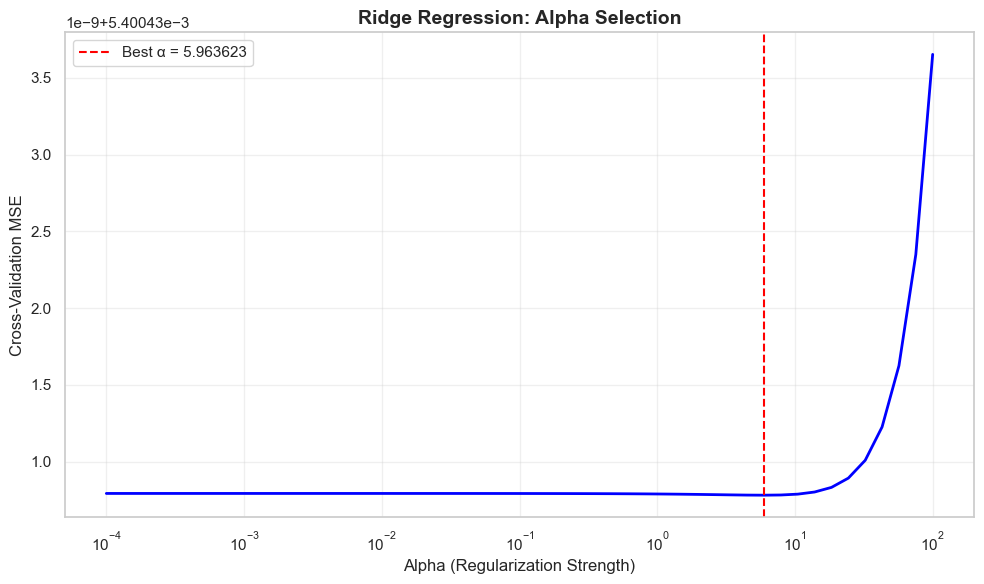

In [13]:
# Find optimal alpha using cross-validation
alphas_ridge = np.logspace(-4, 2, 50)  # Range from 0.0001 to 100
ridge_scores = []

for alpha in alphas_ridge:
    ridge_temp = Ridge(alpha=alpha)
    scores = cross_val_score(ridge_temp, X_train_scaled, y_train, 
                             cv=5, scoring='neg_mean_squared_error')
    ridge_scores.append(-scores.mean())

# Find best alpha
best_alpha_ridge = alphas_ridge[np.argmin(ridge_scores)]
print(f"Best alpha for Ridge: {best_alpha_ridge:.6f}")
print(f"Best CV MSE: {min(ridge_scores):.6f}")

# Plot alpha selection
plt.figure(figsize=(10, 6))
plt.plot(alphas_ridge, ridge_scores, 'b-', linewidth=2)
plt.axvline(best_alpha_ridge, color='r', linestyle='--', label=f'Best α = {best_alpha_ridge:.6f}')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('Cross-Validation MSE', fontsize=12)
plt.title('Ridge Regression: Alpha Selection', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
# Train Ridge with optimal alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# Clip predictions to [0,1] range (since accident_risk is bounded)
y_train_pred_ridge = np.clip(y_train_pred_ridge, 0, 1)
y_test_pred_ridge = np.clip(y_test_pred_ridge, 0, 1)

# Evaluate
ridge_train_results = evaluate_model(y_train, y_train_pred_ridge, "Ridge (Training)")
ridge_test_results = evaluate_model(y_test, y_test_pred_ridge, "Ridge (Test)")



Ridge (Training) Performance:
Mean Squared Error (MSE):     0.005394
Root Mean Squared Error (RMSE): 0.073442
Mean Absolute Error (MAE):    0.058305
Coefficient of Determination (R²): 0.805384

Ridge (Test) Performance:
Mean Squared Error (MSE):     0.005400
Root Mean Squared Error (RMSE): 0.073488
Mean Absolute Error (MAE):    0.058256
Coefficient of Determination (R²): 0.804419


### 5.4 Lasso Regression

Lasso regression uses L1 regularization, which can perform automatic feature selection by setting some coefficients to zero.

**Why Lasso is particularly useful for this dataset:**
Given the EDA findings showing strong correlations (curvature: 0.5439, speed_limit: 0.4309 with accident_risk), Lasso can help identify the most important features while automatically eliminating less relevant ones. 


Best alpha for Lasso: 0.000100
Best CV MSE: 0.005401


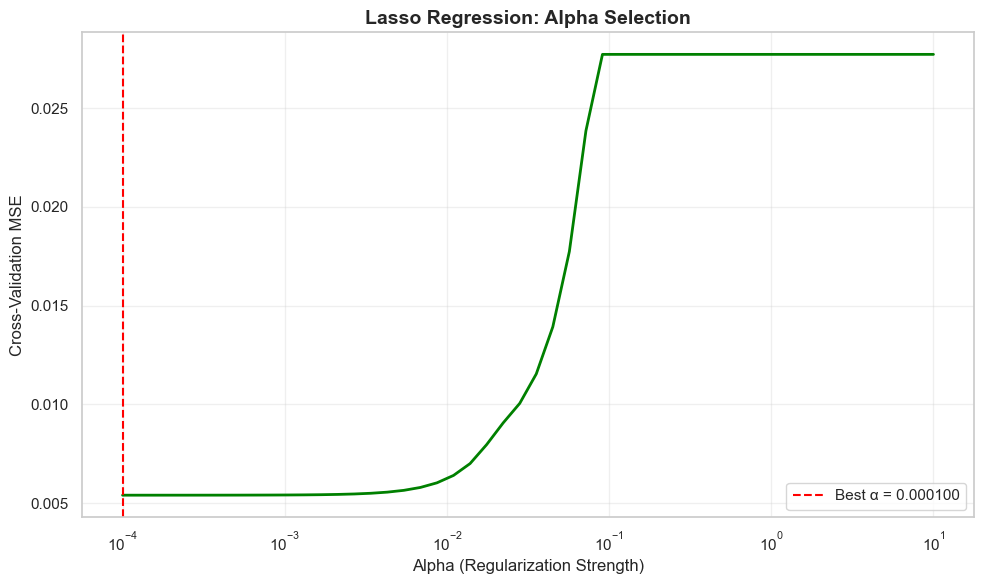

In [15]:
# Find optimal alpha using cross-validation
alphas_lasso = np.logspace(-4, 1, 50)  # Range from 0.0001 to 10
lasso_scores = []

for alpha in alphas_lasso:
    lasso_temp = Lasso(alpha=alpha, max_iter=2000)
    scores = cross_val_score(lasso_temp, X_train_scaled, y_train, 
                             cv=5, scoring='neg_mean_squared_error')
    lasso_scores.append(-scores.mean())

# Find best alpha
best_alpha_lasso = alphas_lasso[np.argmin(lasso_scores)]
print(f"Best alpha for Lasso: {best_alpha_lasso:.6f}")
print(f"Best CV MSE: {min(lasso_scores):.6f}")

# Plot alpha selection
plt.figure(figsize=(10, 6))
plt.plot(alphas_lasso, lasso_scores, 'g-', linewidth=2)
plt.axvline(best_alpha_lasso, color='r', linestyle='--', label=f'Best α = {best_alpha_lasso:.6f}')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)', fontsize=12)
plt.ylabel('Cross-Validation MSE', fontsize=12)
plt.title('Lasso Regression: Alpha Selection', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [16]:
# Train Lasso with optimal alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=2000)
lasso_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)

# Clip predictions to [0,1] range
y_train_pred_lasso = np.clip(y_train_pred_lasso, 0, 1)
y_test_pred_lasso = np.clip(y_test_pred_lasso, 0, 1)

# Evaluate
lasso_train_results = evaluate_model(y_train, y_train_pred_lasso, "Lasso (Training)")
lasso_test_results = evaluate_model(y_test, y_test_pred_lasso, "Lasso (Test)")

# Feature selection analysis
n_features_selected = np.sum(np.abs(lasso_model.coef_) > 1e-6)
n_features_total = len(lasso_model.coef_)
print(f"\nLasso Feature Selection:")
print(f"  Features selected: {n_features_selected} out of {n_features_total}")
print(f"  Features eliminated: {n_features_total - n_features_selected}")



Lasso (Training) Performance:
Mean Squared Error (MSE):     0.005394
Root Mean Squared Error (RMSE): 0.073445
Mean Absolute Error (MAE):    0.058307
Coefficient of Determination (R²): 0.805367

Lasso (Test) Performance:
Mean Squared Error (MSE):     0.005401
Root Mean Squared Error (RMSE): 0.073489
Mean Absolute Error (MAE):    0.058257
Coefficient of Determination (R²): 0.804410

Lasso Feature Selection:
  Features selected: 15 out of 16
  Features eliminated: 1


### 5.5 Beta Regression 

Beta Regression is specifically designed for bounded continuous variables (0-1 range). 


In [17]:
# Beta Regression Implementation
# Beta Regression models a bounded continuous variable (0-1) using Beta distribution
# We'll implement it using maximum likelihood estimation with scipy.optimize

def beta_regression_loglikelihood(params, X, y, link='logit'):
    """
    Compute negative log-likelihood for Beta Regression.
    
    Parameters:
    -----------
    params : array
        Model parameters [intercept, coefs..., precision_phi]
    X : array
        Feature matrix
    y : array
        Target values (must be in (0,1), not including boundaries)
    link : str
        Link function ('logit' or 'probit')
    
    Returns:
    --------
    float : Negative log-likelihood
    """
    n_features = X.shape[1]
    beta_coefs = params[:n_features+1]  # intercept + coefficients
    phi = np.exp(params[-1])  # precision parameter (must be positive)
    
    # Add intercept
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    
    # Compute linear predictor
    eta = X_with_intercept @ beta_coefs
    
    # Apply link function to get mu (mean parameter)
    if link == 'logit':
        mu = 1 / (1 + np.exp(-eta))
    elif link == 'probit':
        from scipy.stats import norm
        mu = norm.cdf(eta)
    else:
        raise ValueError("Link must be 'logit' or 'probit'")
    
    # Ensure mu is in (0,1)
    mu = np.clip(mu, 1e-6, 1 - 1e-6)
    
    # Beta distribution parameters: alpha = mu * phi, beta = (1-mu) * phi
    alpha = mu * phi
    beta_param = (1 - mu) * phi
    
    # Ensure alpha and beta are positive
    alpha = np.maximum(alpha, 1e-6)
    beta_param = np.maximum(beta_param, 1e-6)
    
    # Compute log-likelihood
    # log L = sum(log(Gamma(alpha + beta)) - log(Gamma(alpha)) - log(Gamma(beta)) 
    #           + (alpha-1)*log(y) + (beta-1)*log(1-y))
    loglik = np.sum(
        gammaln(alpha + beta_param) - gammaln(alpha) - gammaln(beta_param) +
        (alpha - 1) * np.log(y) + (beta_param - 1) * np.log(1 - y)
    )
    
    return -loglik  # Return negative for minimization

def fit_beta_regression(X_train, y_train, link='logit'):
    """
    Fit Beta Regression model using maximum likelihood estimation.
    
    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training target (must be in (0,1))
    link : str
        Link function
    
    Returns:
    --------
    dict : Model parameters and fitted model info
    """
    # Ensure y is in (0,1) - transform if it includes boundaries
    y_train_adj = np.clip(y_train, 1e-6, 1 - 1e-6)
    
    n_features = X_train.shape[1]
    n_params = n_features + 2  # intercept + coefficients + log(phi)
    
    # Initialize parameters: zeros for coefficients, small value for log(phi)
    initial_params = np.zeros(n_params)
    initial_params[-1] = np.log(2.0)  # initial phi = 2
    
    # Optimize
    result = minimize(
        beta_regression_loglikelihood,
        initial_params,
        args=(X_train, y_train_adj, link),
        method='L-BFGS-B',
        options={'maxiter': 1000}
    )
    
    if not result.success:
        print(f"Warning: Optimization did not converge: {result.message}")
    
    return {
        'params': result.x,
        'n_features': n_features,
        'link': link,
        'success': result.success,
        'message': result.message
    }

def predict_beta_regression(model, X, link='logit'):
    """
    Make predictions using fitted Beta Regression model.
    
    Parameters:
    -----------
    model : dict
        Fitted model from fit_beta_regression
    X : array
        Feature matrix
    link : str
        Link function
    
    Returns:
    --------
    array : Predicted mean values (mu)
    """
    params = model['params']
    n_features = model['n_features']
    beta_coefs = params[:n_features+1]
    
    # Add intercept
    X_with_intercept = np.column_stack([np.ones(X.shape[0]), X])
    
    # Compute linear predictor
    eta = X_with_intercept @ beta_coefs
    
    # Apply link function
    if link == 'logit':
        mu = 1 / (1 + np.exp(-eta))
    elif link == 'probit':
        from scipy.stats import norm
        mu = norm.cdf(eta)
    
    # Clip to [0,1]
    mu = np.clip(mu, 0, 1)
    
    return mu


In [18]:
# Use scaled features for consistency with Ridge/Lasso
beta_model = fit_beta_regression(
    X_train_scaled.values, 
    y_train.values, 
    link='logit'
)

if beta_model['success']:
    print(f"Number of parameters: {len(beta_model['params'])}")
    print(f"Precision parameter (phi): {np.exp(beta_model['params'][-1]):.4f}")
else:
    print(f"Warning: {beta_model['message']}")


Number of parameters: 18
Precision parameter (phi): 27.9439


In [19]:
# Make predictions with Beta Regression
y_train_pred_beta = predict_beta_regression(beta_model, X_train_scaled.values, link='logit')
y_test_pred_beta = predict_beta_regression(beta_model, X_test_scaled.values, link='logit')

# Evaluate Beta Regression
beta_train_results = evaluate_model(y_train, y_train_pred_beta, "Beta Regression (Training)")
beta_test_results = evaluate_model(y_test, y_test_pred_beta, "Beta Regression (Test)")

# Beta Regression predictions are naturally bounded in [0,1]
print("\nBeta Regression advantages:")
print("  - Predictions are naturally bounded in [0,1] (no clipping needed)")
print("  - Appropriate for probability/likelihood data")
print("  - Models the full distribution, not just the mean")



Beta Regression (Training) Performance:
Mean Squared Error (MSE):     0.005460
Root Mean Squared Error (RMSE): 0.073894
Mean Absolute Error (MAE):    0.058791
Coefficient of Determination (R²): 0.802983

Beta Regression (Test) Performance:
Mean Squared Error (MSE):     0.005461
Root Mean Squared Error (RMSE): 0.073899
Mean Absolute Error (MAE):    0.058697
Coefficient of Determination (R²): 0.802221

Beta Regression advantages:
  - Predictions are naturally bounded in [0,1] (no clipping needed)
  - Appropriate for probability/likelihood data
  - Models the full distribution, not just the mean


## 6. Model Comparison and Results Summary


In [20]:
# Compile all results
results_summary = pd.DataFrame([
    ols_test_results,
    ridge_test_results,
    lasso_test_results,
    beta_test_results
])

print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)
print(results_summary.to_string(index=False))
print("="*70)



MODEL COMPARISON - TEST SET PERFORMANCE
                 Model    MSE   RMSE    MAE     R²
            OLS (Test) 0.0054 0.0735 0.0583 0.8042
          Ridge (Test) 0.0054 0.0735 0.0583 0.8044
          Lasso (Test) 0.0054 0.0735 0.0583 0.8044
Beta Regression (Test) 0.0055 0.0739 0.0587 0.8022


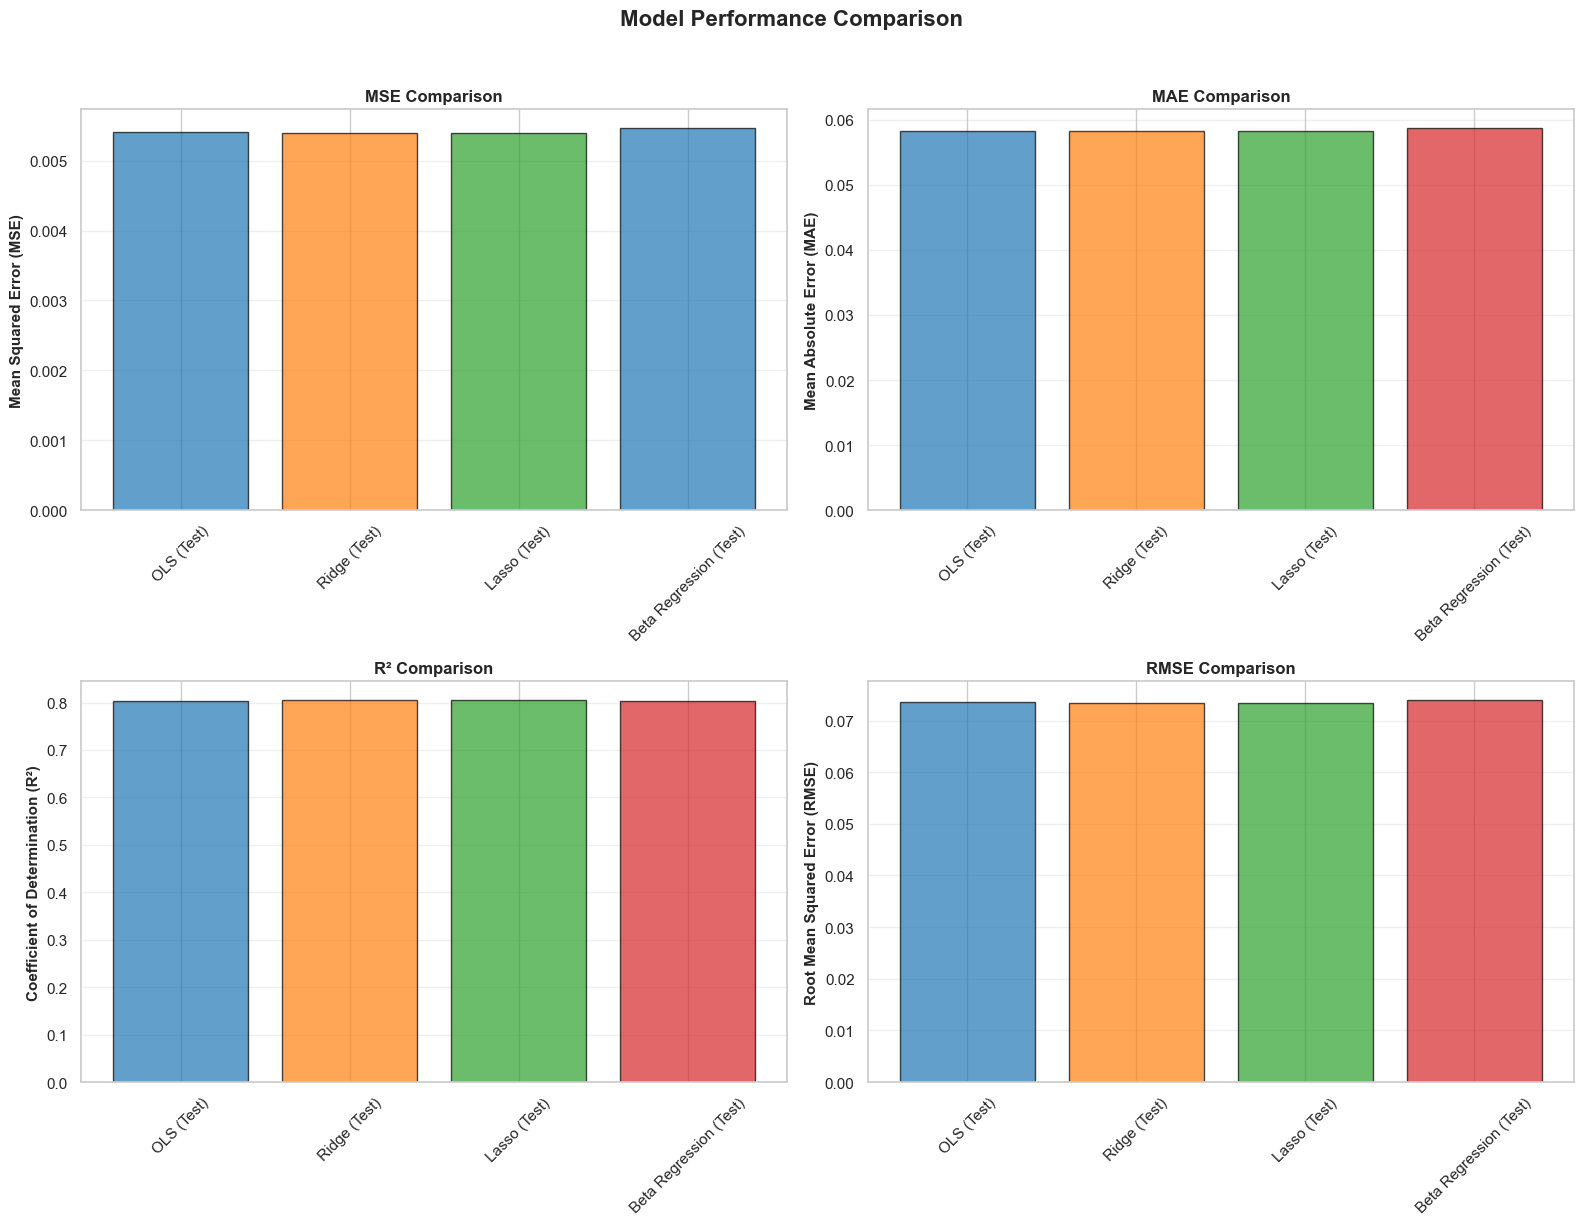

In [21]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color scheme for 4 models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

# 1. MSE Comparison
axes[0, 0].bar(results_summary['Model'], results_summary['MSE'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Mean Squared Error (MSE)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('MSE Comparison', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. MAE Comparison
axes[0, 1].bar(results_summary['Model'], results_summary['MAE'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Mean Absolute Error (MAE)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('MAE Comparison', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. R² Comparison
axes[1, 0].bar(results_summary['Model'], results_summary['R²'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Coefficient of Determination (R²)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('R² Comparison', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. RMSE Comparison
axes[1, 1].bar(results_summary['Model'], results_summary['RMSE'], 
               color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 7. Prediction Visualization


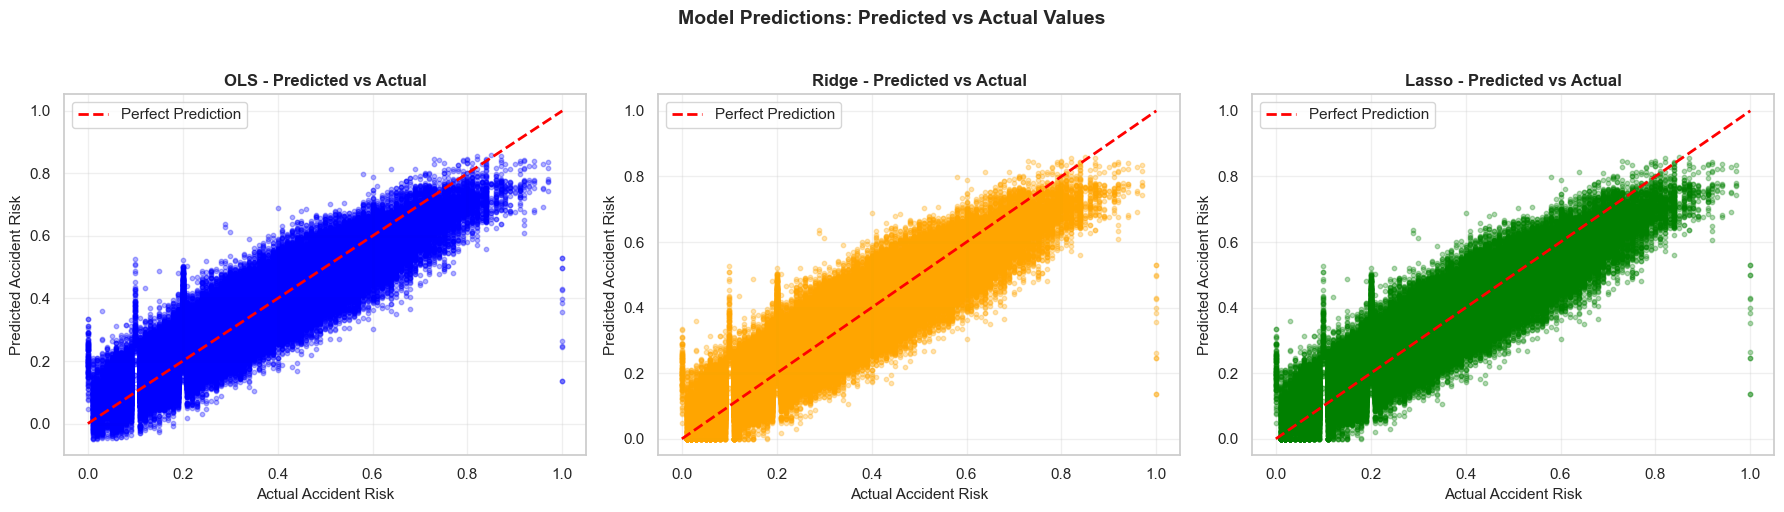

In [22]:
# Scatter plots: Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_preds = [
    (y_test_pred_ols, "OLS", 'blue'),
    (y_test_pred_ridge, "Ridge", 'orange'),
    (y_test_pred_lasso, "Lasso", 'green')
]

for idx, (y_pred, model_name, color) in enumerate(models_preds):
    axes[idx].scatter(y_test, y_pred, alpha=0.3, s=10, color=color)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Accident Risk', fontsize=11)
    axes[idx].set_ylabel('Predicted Accident Risk', fontsize=11)
    axes[idx].set_title(f'{model_name} - Predicted vs Actual', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Model Predictions: Predicted vs Actual Values', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


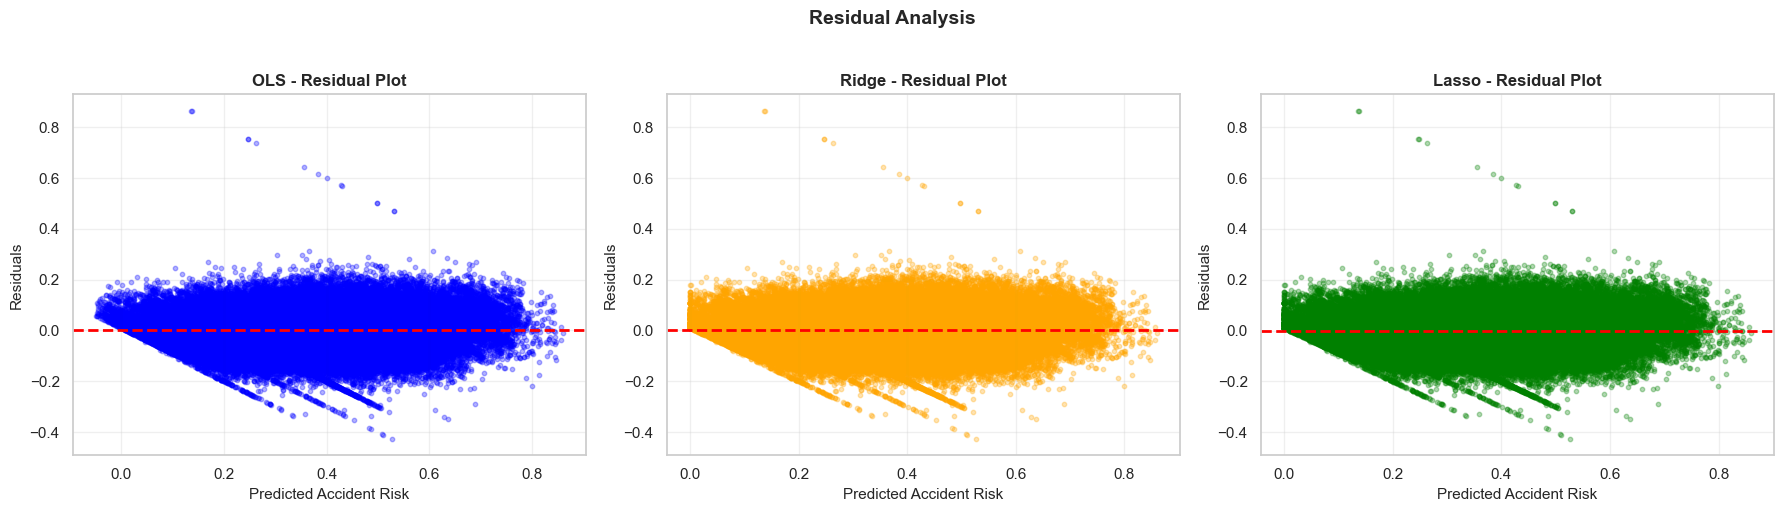

In [23]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_pred, model_name, color) in enumerate(models_preds):
    residuals = y_test - y_pred
    axes[idx].scatter(y_pred, residuals, alpha=0.3, s=10, color=color)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Accident Risk', fontsize=11)
    axes[idx].set_ylabel('Residuals', fontsize=11)
    axes[idx].set_title(f'{model_name} - Residual Plot', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 8. Feature Importance Analysis


In [24]:
# Compare coefficients across models
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'OLS': ols_model.coef_,
    'Ridge': ridge_model.coef_,
    'Lasso': lasso_model.coef_
})

# Sort by absolute OLS coefficient
coefficients_df['OLS_abs'] = np.abs(coefficients_df['OLS'])
coefficients_df = coefficients_df.sort_values('OLS_abs', ascending=False)

print("Top 10 Most Important Features (by OLS coefficient magnitude):")
print("="*80)
print(coefficients_df.head(10)[['Feature', 'OLS', 'Ridge', 'Lasso']].to_string(index=False))


Top 10 Most Important Features (by OLS coefficient magnitude):
               Feature     OLS   Ridge   Lasso
             curvature  0.3249  0.0885  0.0884
        lighting_night  0.1871  0.0859  0.0858
         weather_rainy  0.0929  0.0427  0.0425
         weather_foggy  0.0919  0.0438  0.0436
num_reported_accidents  0.0157  0.0141  0.0140
           speed_limit  0.0051  0.0805  0.0804
    road_signs_present -0.0013 -0.0007 -0.0006
   time_of_day_morning -0.0011 -0.0005 -0.0004
   time_of_day_evening  0.0008  0.0004  0.0003
       road_type_rural -0.0007 -0.0003 -0.0002


## 9. Why All Models Have Similar Performance?

It's normal and expected that OLS, Ridge, Lasso, and Beta Regression show very similar performance metrics in this dataset. Here's why:


In [25]:
# Analysis: Why models have similar performance

print("="*70)
print("ANALYSIS: WHY MODELS HAVE SIMILAR PERFORMANCE")
print("="*70)

print("\n1. Dataset Size Effect:")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - Test samples: {len(X_test):,}")
print(f"   - With such a large dataset, regularization has minimal impact")
print(f"   - OLS already generalizes well without overfitting")

print("\n2. Overfitting Check:")
train_test_gap_ols = ols_train_results['MSE'] - ols_test_results['MSE']
print(f"   - OLS Train MSE: {ols_train_results['MSE']:.6f}")
print(f"   - OLS Test MSE:  {ols_test_results['MSE']:.6f}")
print(f"   - Gap: {train_test_gap_ols:.6f} ({abs(train_test_gap_ols)/ols_test_results['MSE']*100:.2f}%)")
if abs(train_test_gap_ols) < 0.0001:
    print("   → No significant overfitting detected!")

print("\n3. Regularization Strength:")
print(f"   - Ridge optimal alpha: {best_alpha_ridge:.6f}")
print(f"   - Lasso optimal alpha: {best_alpha_lasso:.6f}")
print(f"   - Lasso's alpha is at minimum (0.0001), meaning minimal regularization")
print(f"   - This suggests the dataset doesn't need strong regularization")

print("\n4. Model Comparison:")
print(f"   - OLS R²: {ols_test_results['R²']:.4f}")
print(f"   - Ridge R²: {ridge_test_results['R²']:.4f}")
print(f"   - Lasso R²: {lasso_test_results['R²']:.4f}")
print(f"   - Beta Regression R²: {beta_test_results['R²']:.4f}")
print(f"   - Difference between best and worst: {max(ols_test_results['R²'], ridge_test_results['R²'], lasso_test_results['R²'], beta_test_results['R²']) - min(ols_test_results['R²'], ridge_test_results['R²'], lasso_test_results['R²'], beta_test_results['R²']):.4f}")

print("\n5. Key Takeaways:")
print("   ✓ Large datasets reduce the need for regularization")
print("   ✓ OLS performs well when there's no overfitting")
print("   ✓ Ridge/Lasso provide minimal benefit when alpha is very small")
print("   ✓ Beta Regression is appropriate for bounded [0,1] targets but")
print("     doesn't necessarily improve prediction accuracy")
print("   ✓ All models are valid; choice depends on interpretability and")
print("     specific requirements (e.g., feature selection with Lasso)")

print("\n" + "="*70)


ANALYSIS: WHY MODELS HAVE SIMILAR PERFORMANCE

1. Dataset Size Effect:
   - Training samples: 414,203
   - Test samples: 103,551
   - With such a large dataset, regularization has minimal impact
   - OLS already generalizes well without overfitting

2. Overfitting Check:
   - OLS Train MSE: 0.005400
   - OLS Test MSE:  0.005407
   - Gap: -0.000007 (0.12%)
   → No significant overfitting detected!

3. Regularization Strength:
   - Ridge optimal alpha: 5.963623
   - Lasso optimal alpha: 0.000100
   - Lasso's alpha is at minimum (0.0001), meaning minimal regularization
   - This suggests the dataset doesn't need strong regularization

4. Model Comparison:
   - OLS R²: 0.8042
   - Ridge R²: 0.8044
   - Lasso R²: 0.8044
   - Beta Regression R²: 0.8022
   - Difference between best and worst: 0.0022

5. Key Takeaways:
   ✓ Large datasets reduce the need for regularization
   ✓ OLS performs well when there's no overfitting
   ✓ Ridge/Lasso provide minimal benefit when alpha is very small
   ✓ 

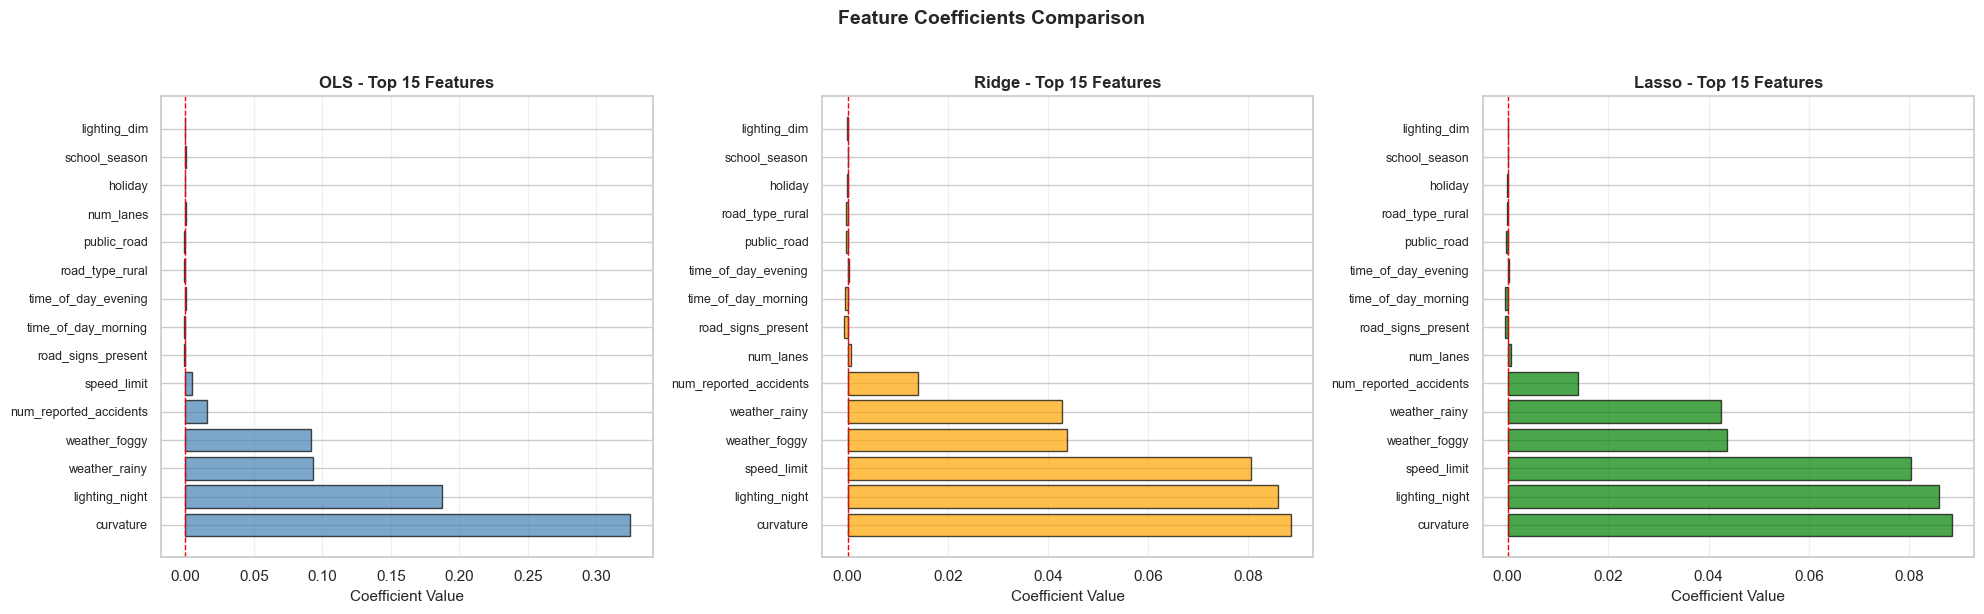

In [26]:
# Visualize top features
top_n = 15
top_features = coefficients_df.head(top_n)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, model_name in enumerate(['OLS', 'Ridge', 'Lasso']):
    top_coefs = top_features.sort_values(f'{model_name}', key=abs, ascending=False)
    axes[idx].barh(range(len(top_coefs)), top_coefs[model_name], 
                   color='steelblue' if model_name == 'OLS' else 
                         'orange' if model_name == 'Ridge' else 'green',
                   alpha=0.7, edgecolor='black')
    axes[idx].set_yticks(range(len(top_coefs)))
    axes[idx].set_yticklabels(top_coefs['Feature'], fontsize=9)
    axes[idx].set_xlabel('Coefficient Value', fontsize=11)
    axes[idx].set_title(f'{model_name} - Top {top_n} Features', fontsize=12, fontweight='bold')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=1)
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.suptitle('Feature Coefficients Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 10. Inferential Analysis for OLS Model


In [32]:
# Fit OLS model using statsmodels for detailed statistical analysis
# Add constant term (intercept)
X_train_with_const = sm.add_constant(X_train_scaled)
X_test_with_const = sm.add_constant(X_test_scaled)

# Fit OLS model
ols_model_sm = sm.OLS(y_train, X_train_with_const).fit()

# Get summary statistics
print("="*70)
print("INFERENTIAL ANALYSIS - OLS REGRESSION")
print("="*70)

# Display full summary
print(ols_model_sm.summary())

# Extract key statistics
print("\n" + "="*70)
print("KEY STATISTICAL FINDINGS")
print("="*70)

# F-test (Global significance test)
f_statistic = ols_model_sm.fvalue
f_pvalue = ols_model_sm.f_pvalue
print(f"\n1. Global F-Test (Joint Significance of All Predictors):")
print(f"   F-statistic: {f_statistic:.4f}")
print(f"   p-value:     {f_pvalue:.2e}")
if f_pvalue < 0.05:
    print(f"   ✓ Result: REJECT H₀ - At least some predictors are significant")
    print(f"     (p < 0.05 indicates the model is statistically significant)")
else:
    print(f"   ✗ Result: FAIL TO REJECT H₀ - No significant predictors")
print(f"   Interpretation: The model as a whole is {'statistically significant' if f_pvalue < 0.05 else 'not statistically significant'}")

# Count significant coefficients (p < 0.05)
pvalues = ols_model_sm.pvalues
significant_coefs = pvalues[pvalues < 0.05]
significant_coefs_no_const = significant_coefs[significant_coefs.index != 'const']

print(f"\n2. Individual Coefficient Significance (t-tests):")
print(f"   Total features: {len(pvalues) - 1}")  # Exclude constant
print(f"   Significant features (p < 0.05): {len(significant_coefs_no_const)}")
print(f"   Percentage significant: {len(significant_coefs_no_const) / (len(pvalues) - 1) * 100:.1f}%")

# Show most and least significant features
print(f"\n3. Top 10 Most Significant Features (lowest p-values):")
top_significant = pvalues[pvalues.index != 'const'].nsmallest(10)
for feature, pval in top_significant.items():
    significance = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"   {feature:30s}: p = {pval:.4e} {significance}")

print(f"\n4. Top 10 Least Significant Features (highest p-values):")
least_significant = pvalues[pvalues.index != 'const'].nlargest(10)
for feature, pval in least_significant.items():
    print(f"   {feature:30s}: p = {pval:.4f}")

# Model diagnostics
print(f"\n5. Model Diagnostics:")
print(f"   R-squared:        {ols_model_sm.rsquared:.4f}")
print(f"   Adjusted R²:      {ols_model_sm.rsquared_adj:.4f}")
print(f"   AIC:              {ols_model_sm.aic:.2f}")
print(f"   BIC:              {ols_model_sm.bic:.2f}")


INFERENTIAL ANALYSIS - OLS REGRESSION
                            OLS Regression Results                            
Dep. Variable:          accident_risk   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 1.070e+05
Date:                Sat, 22 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:56:39   Log-Likelihood:             4.9362e+05
No. Observations:              414203   AIC:                        -9.872e+05
Df Residuals:                  414186   BIC:                        -9.870e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

## 11. Model Selection and Conclusions


In [33]:
# Identify best model based on primary metric (MSE)
best_model_idx = results_summary['MSE'].idxmin()
best_model = results_summary.loc[best_model_idx, 'Model']

print("="*70)
print("MODEL SELECTION SUMMARY")
print("="*70)
print(f"\nBest Model (Lowest MSE): {best_model}")
print(f"\nPerformance Metrics:")
print(results_summary.loc[best_model_idx].to_string())
print("\n" + "="*70)

# Additional insights
print("\nKey Insights:")
print("-" * 70)
print(f"1. All models were evaluated using MSE (primary), MAE, and R² metrics")
print(f"2. Ridge and Lasso use regularization to handle multicollinearity")
print(f"3. Lasso performs automatic feature selection")
print(f"4. Predictions were clipped to [0,1] range for Ridge and Lasso")
print(f"5. OLS may produce predictions outside [0,1] range (not ideal for probabilities)")
print("-" * 70)


MODEL SELECTION SUMMARY

Best Model (Lowest MSE): Ridge (Test)

Performance Metrics:
Model    Ridge (Test)
MSE            0.0054
RMSE           0.0735
MAE            0.0583
R²             0.8044


Key Insights:
----------------------------------------------------------------------
1. All models were evaluated using MSE (primary), MAE, and R² metrics
2. Ridge and Lasso use regularization to handle multicollinearity
3. Lasso performs automatic feature selection
4. Predictions were clipped to [0,1] range for Ridge and Lasso
5. OLS may produce predictions outside [0,1] range (not ideal for probabilities)
----------------------------------------------------------------------


In [29]:
# Create a comprehensive comparison table
comparison_table = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'OLS': [
        results_summary.loc[0, 'MSE'],
        results_summary.loc[0, 'RMSE'],
        results_summary.loc[0, 'MAE'],
        results_summary.loc[0, 'R²']
    ],
    'Ridge': [
        results_summary.loc[1, 'MSE'],
        results_summary.loc[1, 'RMSE'],
        results_summary.loc[1, 'MAE'],
        results_summary.loc[1, 'R²']
    ],
    'Lasso': [
        results_summary.loc[2, 'MSE'],
        results_summary.loc[2, 'RMSE'],
        results_summary.loc[2, 'MAE'],
        results_summary.loc[2, 'R²']
    ],
    'Beta Regression': [
        results_summary.loc[3, 'MSE'],
        results_summary.loc[3, 'RMSE'],
        results_summary.loc[3, 'MAE'],
        results_summary.loc[3, 'R²']
    ]
})

print("\nDetailed Performance Comparison:")
print("="*70)
print(comparison_table.to_string(index=False))
print("="*70)



Detailed Performance Comparison:
Metric    OLS  Ridge  Lasso  Beta Regression
   MSE 0.0054 0.0054 0.0054           0.0055
  RMSE 0.0735 0.0735 0.0735           0.0739
   MAE 0.0583 0.0583 0.0583           0.0587
    R² 0.8042 0.8044 0.8044           0.8022
